# **Global Sentiment**

En este cuaderno mostraremos la forma de extraer el *Sentimiento Global*, métrica que hemos desarrollado para este proyecto.

## ¿Que es el Sentimiento Global?

Normalmente, cuando miramos el "sentimiento" de un Tweet, lo hacemos fijandonos en la polaridad del mismo. Una vez se consiguen todas las polaridades, la mayoria de herramientas que hemos visto, usan la media del "sentimiento" como medida de Sentimiento Global en Twitter.

* https://alternative.me/crypto/fear-and-greed-index/
* https://www.crypto-sentiment.com/
* https://www.bittsanalytics.com/sentiment-index/BTC

Nosotros rechazamos esta idea. 

Para encontrar una métrica más efectiva, planteamos la siguiente fórmula:

$$S(P) = \sum_{m \in P} m_s * (1 + \log_2(1 + m_l))$$

donde $S(P)$ es un mapeo de una lista de mensajes a un número real, $P$ es una lista de mensajes de un periodo conexo de tiempo, $m_s$ es la polaridad de un mensaje y $m_l$ es el *impacto* de un tweet, en este caso, los likes.

Se pueden considerar diferentes formas de impacto haciendo uso del número de contestaciones, retweets, likes, likes a las contestaciones, etc, pero en este estudio vamos a mantener la simplicidad.


## Imports y Parametros

In [1]:
import datetime
from datetime import timedelta

import os
import re

import snscrape.modules.twitter as snstwitter

import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

Podemos escoger las fechas que queremos analizar. Para poder analizarlas, debemos tener los archivos de las fechas correspondientes descargados, sino no podremos ejecutar el analisis.

In [2]:
date_init = "2017-01-02"
date_limit = "2021-06-14"

## **Read Databases**

Definimos la carpeta donde se encuentran los datos así como los nombres de los archivos.

In [3]:
t_path = "JABA/data/tweets"
t_file = "tweet_list.csv"
s_file = "tweet_sentiment_nltk.csv"

La base de datos esta formada por millones de filas y no usaremos todas las columnas, por lo que, para acelerar el proceso, eliminaremos las columnas no usadas.

In [22]:
unused_columns = ['Tweet Id', 'NumReplies', 'NumRetweets', 'IDOriginalRetweeted', 'isVerified'  ]

def drop_unused_columns(dataframe):
    return dataframe.drop(unused_columns,  axis=1)

Para preparar los datos haremos un conjunto de transformaciones que tienen los siguientes objetivos:

* Preparar la fila de Sentimiento Global
* Agrupar los datos por cada media hora
* Preparar la fila de Sentimiento Global V2

In [48]:

def prepare_data(dataframe):
    dataframe["Datetime"] = pd.to_datetime(dataframe["Datetime"])
    dataframe['sentiment_real'] = 0
    for index, row in dataframe.iterrows():
        dataframe.loc[index]['sentiment_real'] = a.get_sentiment(dataframe.iloc[index]['Text'])
    dataframe['sentiment_real_v'] = ( 1 + np.log2(1 + dataframe['NumLikes']) ) * dataframe['sentiment_real'] 
    dataframe['sentiment_v'] = ( 1 + np.log2(1 + dataframe['NumLikes']) ) * dataframe['sentiment'] 
    dataframe["round_datetime"] = dataframe["Datetime"].dt.floor("30T")
    
    dataframe["date"] = dataframe["Datetime"].dt.date
    dataframe = dataframe.set_index('date')
    
    dataframe = dataframe.groupby(['round_datetime', 'Username']).agg({'sentiment_v' : 'sum' , 'Datetime':'count'})

    dataframe['sentiment_v2'] = np.log2(1+dataframe['Datetime']) / dataframe['Datetime'] * dataframe['sentiment_v']
    return dataframe.groupby('round_datetime').sum()

Definimos una función que recoja los archivos de las fechas correspondientes, los limpie y los una.

In [49]:
def get_data():
    frames = []
    date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
    date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()
    
    if date_from >= date_until:
        return pd.DataFrame()
    
    while date_from < date_until:
        
        folder = os.path.join(t_path, str(date_from))
        # TODO Check if file exists
        if date_from.day == 1:
            print(f"Current Date {str(date_from)}")

        tweet_file = os.path.join(folder, t_file)
        sentiment_file = os.path.join(folder, s_file)

        tweet_df = pd.read_csv(tweet_file, sep=";")
        tweet_df = drop_unused_columns(tweet_df)

        sent_df = pd.read_csv(sentiment_file, sep=";")

        tweet_df = prepare_data(tweet_df.join(sent_df))
        
        frames += [tweet_df]
        
        date_from = date_from + timedelta(days=1)
    
    return pd.concat(frames, ignore_index=False)

In [50]:
df = get_data()
print("Extraction Completed!")

<ipython-input-48-b61b81710623>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[index]['sentiment_real'] = a.get_sentiment(dataframe.iloc[index]['Text'])


KeyboardInterrupt: 

## **Get Bitcoin Data**

In [8]:
b_path = "JABA/data/bitcoin"
b_file = "bitcoin.csv"

b_limit = date_limit

In [9]:
btc_df = pd.DataFrame()

frames = []
date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()

while date_from < date_until:

    folder = os.path.join(b_path, str(date_from))
    btc_file = os.path.join(folder, b_file)
    # TODO Check if file exists
    if date_from.day == 1 and date_from.month == 1:
        print(f"Current Date {str(date_from)}")

    b_df = pd.read_csv(btc_file, sep=";")
    frames += [b_df]

    date_from = date_from + timedelta(days=1)

btc_df = pd.concat(frames, ignore_index=False)
print("Extraction Completed!")

Current Date 2018-01-01
Current Date 2019-01-01
Current Date 2020-01-01
Current Date 2021-01-01
Extraction Completed!


In [10]:
# Pasar los formatos a los tipos correspondientes
btc_df['round_datetime'] = pd.to_datetime(btc_df['round_datetime'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])

# Pasar las fechas a index para filtrar datos entre fechas indicadas
btc_df = btc_df.set_index('round_datetime')

# Filtrar entre fechas
btc_df = btc_df[date_init:date_limit]

# Aproximar a periodos de 30 minutos
btc_df['timestamp_round'] = btc_df['timestamp'].dt.floor('30T')

# Sustituir los 0's por el último valos no-zero
btc_df['Close'] = btc_df['Close'].replace(to_replace=0, method='ffill')

# Agrupar y hacer la media
btc_df = btc_df.groupby("timestamp_round").mean()

## **Juntar Datos**

In [11]:
btc_df.index = btc_df.index.tz_localize(None)
df.index = df.index.tz_localize(None)

In [12]:
merge = pd.merge(df,btc_df, how='inner', left_index=True, right_index=True)
#merge = pd.merge(merge,df_gb_c, how='inner', left_index=True, right_index=True)

In [13]:
del df, btc_df

In [14]:
merge.head()

,sentiment_v,Datetime,sentiment_v2,Close
2017-01-02 00:00:00,64.974757,185,45.547100,998.174000
2017-01-02 00:30:00,60.986679,154,43.663361,997.968000
2017-01-02 01:00:00,41.555880,164,35.660829,997.753333
2017-01-02 01:30:00,44.695415,129,30.961104,998.275000
2017-01-02 02:00:00,42.712867,153,32.400544,998.551333


## **Mostrar resultados**

Para hacer la visualización más sencilla, ajustaremos los valores de sentimiento a algunos más cercanos al precio de Bitcoin. 

Recordamos que la correlación no se ve afectada por un factor lineal, por lo que este cambio no afecta a nuestro analisis.

El 52 es un número escogido de forma arbitraria pero que funciona.

In [15]:
merge['Close_z'] = merge['Close']
merge['sentiment_vz'] = merge['sentiment_v'] * 52
merge['sentiment_v2z'] = merge['sentiment_v2'] * 52
merge['Datetime_z'] = merge['Datetime'] * 16

Una vez ajustados los valores, podemos plotear la gráfica para ver los resultados

Text(0, 0.5, 'Price (USD)')

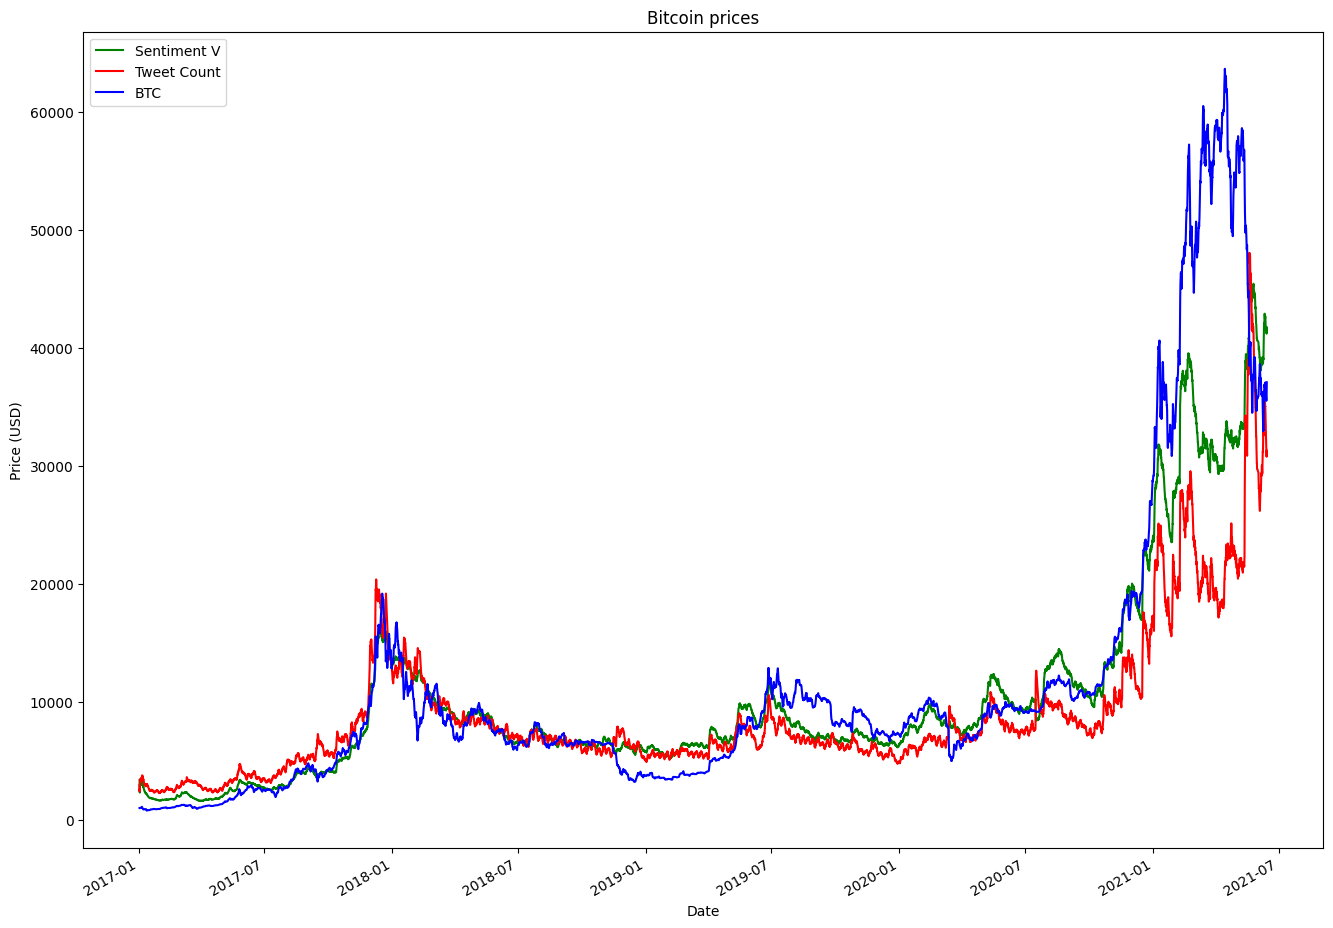

In [16]:
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100

merge['sentiment_vz'].ewm(span = 900).mean().plot(style = 'g', label = 'Sentiment V')
merge['Datetime_z'].ewm(span = 400).mean().plot(style = 'r', label = 'Tweet Count')
merge['Close_z'].ewm(span = 40).mean().plot(style = 'b', label = 'BTC')


plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

### Correlación entre Precio - Sentimiento Global (EWM)

## **Resultados**

In [7]:
from JABA.service.scrapper.analyzer import Analyzer
import pandas as pd

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\whiwho\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\whiwho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     C:\Users\whiwho\AppData\Roaming\nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\whiwho\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\whiwho\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\whiwho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is alre

In [26]:
a = Analyzer()

In [8]:
t_path = "JABA/data/tweets/2017-02-02/tweet_list.csv"
s_path = "JABA/data/tweets/2017-02-02/tweet_sentiment_nltk.csv"

tweet_df = pd.read_csv(t_path, sep=";")
s_df = pd.read_csv(s_path, sep=";")

df = tweet_df.join(s_df)

In [60]:
from transformers import pipeline
print(pipeline('sentiment-analysis')('hate or love wine'))

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_1558']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'POSITIVE', 'score': 0.913642168045044}]


In [55]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
inputs["labels"] = tf.reshape(tf.constant(1), (-1, 1)) # Batch size 1

outputs = model(inputs)
loss = outputs.loss
logits = outputs.logits

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_1478', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use

In [56]:
logits

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.01918146, -0.00967917]], dtype=float32)>

In [51]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="tf")
outputs = model(inputs)

In [54]:
outputs.last_hidden_state

<tf.Tensor: shape=(1, 8, 768), dtype=float32, numpy=
array([[[-1.82963669e-01, -7.40541890e-02,  5.02673350e-02, ...,
         -1.12606846e-01,  4.44931120e-01,  4.09413099e-01],
        [ 7.06231222e-04,  1.48253411e-01,  3.43282342e-01, ...,
         -8.60395133e-02,  6.94747746e-01,  4.33533192e-02],
        [-5.07205307e-01,  5.30854940e-01,  3.71625721e-01, ...,
         -5.62874198e-01,  1.37556791e-01,  2.84752518e-01],
        ...,
        [-4.22513157e-01,  5.73141202e-02,  2.43382752e-01, ...,
         -1.52226716e-01,  2.44624466e-01,  6.41548336e-01],
        [-4.93844301e-01, -1.88954666e-01,  1.26407877e-01, ...,
          6.32407665e-02,  3.69128406e-01, -5.82521409e-02],
        [ 8.32686305e-01,  2.49481708e-01, -4.54395294e-01, ...,
          1.19975254e-01, -3.92573565e-01, -2.77853489e-01]]],
      dtype=float32)>

In [27]:
pipelane = pipeline('sentiment-analysis')
for index,row in df.iterrows():
    if index % 50 == 0:
        print(index)
    if index == 1000:
        break
    df.loc[index,'sentiment_real'] = pipelane(df.loc[index, 'Text'])
    df.loc[index,'sentiment_real'] = df.loc[index,'sentiment_real']['score']

Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized: ['dropout_1439']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [22]:
df.loc[0,'sentiment_real']['score']

0.9828302264213562

In [31]:
df_sent = df[['Text','sentiment', 'sentiment_real']]
df_sent = df_sent[1:1000]

In [39]:
import seaborn as sns

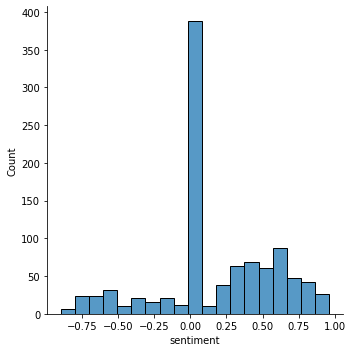

In [41]:
sns.displot(df_sent['sentiment'])

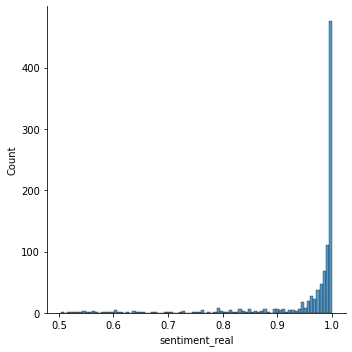

In [40]:
sns.displot(df_sent['sentiment_real'])

In [38]:
for index,row in df_sent.iterrows():
    print("-"*50)
    print(df_sent.loc[index, 'Text'])
    print(f"Sentiment \t {df_sent.loc[index, 'sentiment']} ")
    print(f"SentimenR \t {df_sent.loc[index, 'sentiment_real']} ")

--------------------------------------------------
this is an amazing read on the gritty world of bitcoin mining in venezuela by (h/t tylerwl)
Sentiment 	 0.5859 
SentimenR 	 0.9997534155845642 
--------------------------------------------------
the hodl index score for // is: 1 bitcoin
Sentiment 	 0.6124 
SentimenR 	 0.9973665475845337 
--------------------------------------------------
i deal with it this way - you can't win if you don't fight back and you can't fight back until you know what you're up against.
Sentiment 	 -0.1027 
SentimenR 	 0.5467508435249329 
--------------------------------------------------
stock trade alerts join now promo bitcoin xtnt nrom syn invt pran pzrx irg
Sentiment 	 0.296 
SentimenR 	 0.9974126815795898 
--------------------------------------------------
the oil industry is the enemy of sustainability &amp. renewableenergy in the world. blockchain fintech bitcoin sharingeconomy
Sentiment 	 -0.5423 
SentimenR 	 0.9992701411247253 
---------------------

Sentiment 	 0.7845 
SentimenR 	 0.8230759501457214 
--------------------------------------------------
fc my son once asked me what a bitcoin looked like and i answered "nothing, that's part of the problem" :-)
Sentiment 	 0.5801 
SentimenR 	 0.9983391165733337 
--------------------------------------------------
that daily market break for btc though. sigh
Sentiment 	 0.0258 
SentimenR 	 0.986519455909729 
--------------------------------------------------
the bitcoin startup bitcoin-invests is searching for partner! contact: info
Sentiment 	 0.0 
SentimenR 	 0.9942947030067444 
--------------------------------------------------
tfw her hat actually says "make bitcoin great again". seriously.
Sentiment 	 0.5267 
SentimenR 	 0.9990081191062927 
--------------------------------------------------
"btc miners are fungus" - beautiful analogy, and also very true. competition pushes miners to use 0-cost energy.
Sentiment 	 0.8316 
SentimenR 	 0.9994046092033386 
------------------------------

In [ ]:
for i in range(1:1000):
    print(f"{})